# Impact of Outliers on K-means versus K-medoids

# Project Overview



The aim of this project will be to devise and carry out an analytical approach to measure the effect of outliers on K-means versus K-medoids algorithms using sequence data from the Online Encyclopedia of Integer Sequences (OEIS). In particular the first ten sequence values will be utilized resulting in clustering in ten-dimensional space.  While visual inspection in illustrative cases is often used to highlight the susceptibility of K-means to outliers resulting in poorly formed clusters, quantitatively measuring the impact on non-toy data is less common.

As there are no true class labels in unsupervised learning, and for integer sequences there is no clear intuition from the domain on how sequences should be grouped, some thought is required in constructing corresponding "accuracy" metrics. The approach presented here is to compare the overlap of cluster class labels between a reduced dataset without outliers and the same dataset with the outliers included for both K-means and K-medoids. The labels generated with one of the two datasets are first considered true labels and the accuracy on the other is defined as the matching rate. The true labels are then generated from the second dataset and the process is reversed. As cluster sizes are imbalanced, classification metrics other than accuracy will also be considered for a holistic understanding of efficacy.

As K-medoids requires additional memory and computational complexity, sampling is required to prevent crashing Google Colab. 

The motivation for this project is that clustering sequences may prove useful for some downstream supervised deep learning task as training a single model on all sequences from OEIS may lead to poor performance. Alternatively separate models for each cluster of sequences may be beneficial as the dataset is quite diverse with sequences coming from all branches of mathematics.

The github repository link for this work is located here: https://github.com/HeTalksInMaths/UnsupMLProj-OEIS

# Imports

In [1]:
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns
from scipy.stats import zscore 
import itertools

# Loading Data

The data comes from the Online Encyclopedia of Integer Sequences https://oeis.org/ (Sloane, 1964). This notebook is self-contained and the data is downloaded from a public Google Drive folder. Files were originally downloaed from https://davidbieber.com/snippets/2020-06-28-oeis-download/ (Bieber, 2020).

In [3]:
fileid='1cD9NbA40x9Nu8k2F7pSr3aKhS0VASfip'
filename='oeisvals.csv'

!wget -O $filename 'https://docs.google.com/uc?export=download&id='$fileid


--2022-10-11 19:53:20--  https://docs.google.com/uc?export=download&id=1cD9NbA40x9Nu8k2F7pSr3aKhS0VASfip
Resolving docs.google.com (docs.google.com)... 142.251.107.100, 142.251.107.113, 142.251.107.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.107.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-4k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/g014c3r2ugpets8od3kqp05io1pmljm5/1665517950000/02208792382482262317/*/1cD9NbA40x9Nu8k2F7pSr3aKhS0VASfip?e=download&uuid=d144323f-473b-4566-89e5-49b89bef97cf [following]
--2022-10-11 19:53:23--  https://doc-0o-4k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/g014c3r2ugpets8od3kqp05io1pmljm5/1665517950000/02208792382482262317/*/1cD9NbA40x9Nu8k2F7pSr3aKhS0VASfip?e=download&uuid=d144323f-473b-4566-89e5-49b89bef97cf
Resolving doc-0o-4k-docs.googleusercontent.com (doc-0o-4k-docs.googleusercontent.com)... 172.253.123.132, 2607:

The first ten values for each sequence are extracted from the full dataset for our purposes. 

In [4]:
dfseq = pd.read_csv('/content/oeisvals.csv', header=None, skiprows=4, usecols=range(11), 
                    names=["Sequence", '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

for c in dfseq.columns[1:]:
  dfseq[c] = pd.to_numeric(dfseq[c], errors='coerce', downcast="integer")
  

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Exploratory Data Analysis (EDA)

In [5]:
dfseq.head()

,Sequence,1,2,3,4,5,6,7,8,9,10
0,A000001,0.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,5.0,2.0
1,A000002,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0
2,A000003,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0
3,A000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A000005,1.0,2.0,2.0,3.0,2.0,4.0,2.0,4.0,3.0,4.0


In [6]:
dfseq.shape

(351519, 11)

There are over 350,000 integer sequences but not some may not have ten values so those which do not are dropped.

In [7]:
dfseq.dropna(axis=0, inplace = True)

In [8]:
dfseq.shape

(330583, 11)

Now there are 330,000 sequences however further reduction of the dataset wil be needed. 

We inspect the maximum, mean and median values to get a sense of the distribution of values. Normally a boxplot could be used but extreme outliers make obtaining a meaningful visualization difficult.


In [9]:
np.max(dfseq.iloc[:,1:])

1     1.111111e+127
2      3.402824e+38
3      1.000000e+63
4      2.975857e+79
5     9.046413e+110
6      5.555556e+70
7     2.222222e+205
8     1.307539e+167
9      3.187368e+96
10    8.855667e+163
dtype: float64

In [10]:
np.mean(dfseq.iloc[:,1:])

1     3.734517e+121
2      1.029400e+33
3      6.049918e+57
4      9.002553e+73
5     2.736503e+105
6      1.680533e+65
7     6.722131e+199
8     3.955251e+161
9      9.641659e+90
10    2.678803e+158
dtype: float64

In [11]:
np.median(dfseq.iloc[:,1:], axis=0)

array([  1.,   3.,   6.,  12.,  21.,  33.,  55.,  83., 119., 152.])

It is quite evident that each sequence value is right-skewed with large outliers resulting in mean values significantly larger than the median values.

Sequences with values bounded between $-10^{3}$ and $10^{3}$ are the focus of the work here as otherwise the effect of the outliers is far too obvious and we hope to glean something more subtle in their impact.

In [12]:
dfseq_red = dfseq[(dfseq[dfseq.columns[1:11]] < 1e3).sum(1) > 9]
dfseq_red = dfseq_red[(dfseq_red[dfseq_red.columns[1:11]] > -1e3).sum(1) > 9]

In [13]:
dfseq_red.shape

(189946, 11)

Almost 190,000 sequences still remain with this restriction on the range of values.

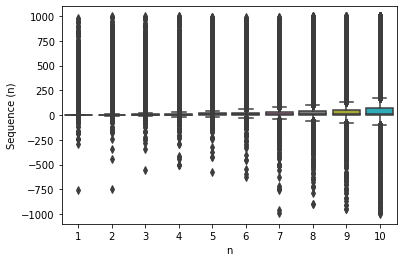

In [14]:
dfseq_red_long = dfseq_red.melt(id_vars = ['Sequence'], value_vars= ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], 
                        var_name='n', value_name='Sequence (n)')

sns.boxplot( x= dfseq_red_long["n"], y= dfseq_red_long["Sequence (n)"] );
plt.show()

Plenty of outliers are observed with comparatively very small interquartile ranges. 

The dataset we consider without outliers will be constructed using sequences where all sequence values are within three standard deviations of the mean sequence value.

In [15]:
X = dfseq_red.drop(columns = ['Sequence'])
X_clean = X[(np.abs(zscore(X)) < 3).all(axis=1)]
X_clean.shape

(177575, 10)

From almost 190,000 sequences, the data without outliers marginally reduces to still over 177,000 sequences. Recall again the ten dimensions for each data point are the first ten sequence values of the sequence.

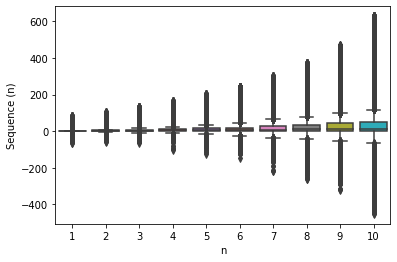

In [16]:
X_clean_long = X_clean.melt(id_vars = [], value_vars= ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], 
                        var_name='n', value_name='Sequence (n)')

sns.boxplot( x= X_clean_long["n"], y= X_clean_long["Sequence (n)"] );
plt.show()

The range of values has now decreased, more prominently so for the earlier sequence values.

As K-means and K-medoids involve distances in high-dimensions, re-scaling is required so that the later sequence values don't have disproportionate impact in determining the clusters.

In [17]:
scaler = StandardScaler()
scaler_fit = scaler.fit(X)
X_std = pd.DataFrame(scaler.transform(X),columns = X.columns, index = X.index)
X_clean_std = pd.DataFrame(scaler.transform(X_clean),columns = X_clean.columns, index = X_clean.index)

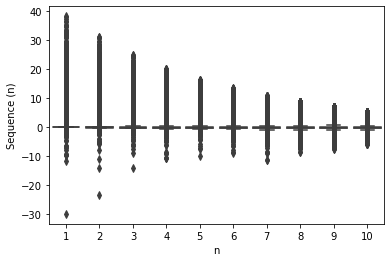

In [18]:
X_std_long = pd.DataFrame(X_std).melt(id_vars = [], value_vars= ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], 
                        var_name='n', value_name='Sequence (n)')

sns.boxplot( x= X_std_long["n"], y= X_std_long["Sequence (n)"] );
plt.show()

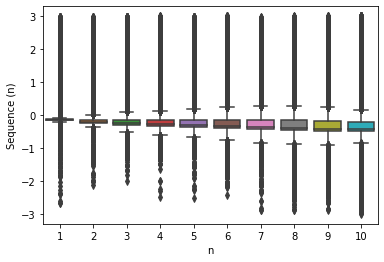

In [19]:
X_clean_std_long = X_clean_std.melt(id_vars = [], value_vars= ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], 
                        var_name='n', value_name='Sequence (n)')

sns.boxplot( x= X_clean_std_long["n"], y= X_clean_std_long["Sequence (n)"] );
plt.show()

The values are now much more manageable after standardizing, especially for the latter boxplot which as expected has values between $-3$ and $3$. The former boxplot with outliers comparatively has values as high as nearly 40.

# Principal Component Analysis (PCA) For Visualization

While quantitative metrics are being used for our analysis, to supplement our understanding, PCA will be used for visualization. The first two principal components for each of the datasets (both with and without outliers) are determined and sequences with their cluster labels will be displayed. Our first set of visualizations will be merely display the data points (sequences) prior to clustering. 

In [20]:
pca = PCA().fit_transform(X_std)

In [21]:
pca2 = PCA().fit_transform(X_clean_std)

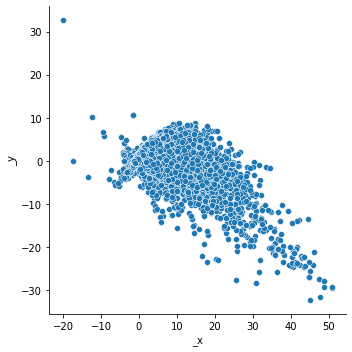

In [22]:
sns.relplot(x=pca[:,0], y=pca[:,1], kind='scatter')

Here is the dataset with outliers and the plot below shows the dataset without outliers.

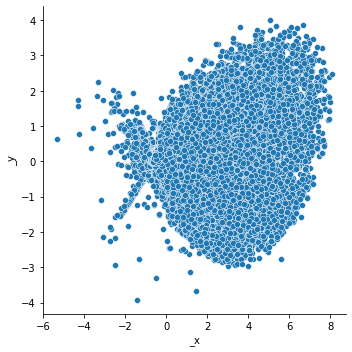

In [23]:
sns.relplot(x=pca2[:,0], y=pca2[:,1], kind='scatter')

The plots don't show an obvious choice for the number of clusters hyperparameter $K$.

# K-means Clustering

 
Elbow plots are constructed to determine an appropriate choice of $K$ for K-means for both datasets.


Text(0.5, 1.0, 'Elbow curve')

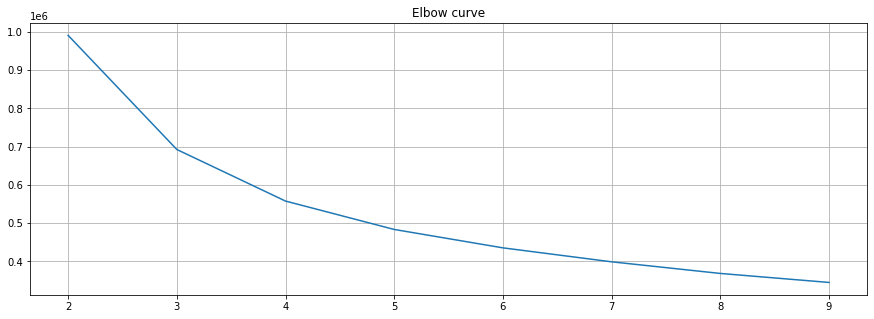

In [24]:
distortsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_std)
    distortsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distortsions)
plt.grid(True)
plt.title('Elbow curve')

Text(0.5, 1.0, 'Elbow curve')

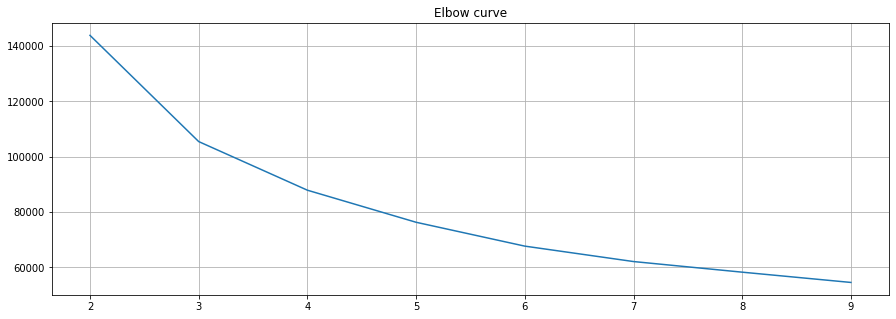

In [25]:
distortsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_clean_std)
    distortsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distortsions)
plt.grid(True)
plt.title('Elbow curve')

Based on the bends in the plot, $K = 3$ appears to be appropriate though $K = 4$ would also be a reasonable choice.

In [26]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_std)
kmeans2 = KMeans(n_clusters=3, random_state=0).fit(X_clean_std)

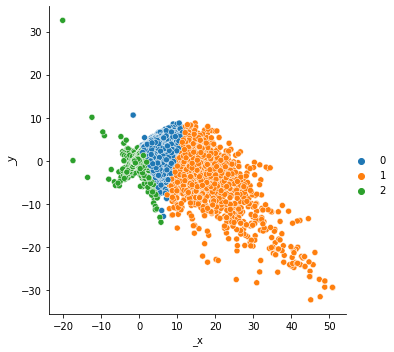

In [27]:
sns.relplot(x=pca[:,0], y=pca[:,1], hue=kmeans.labels_, palette='tab10', kind='scatter')

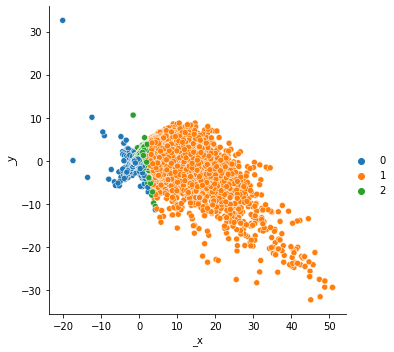

In [28]:
preds = kmeans2.predict(X_std)
sns.relplot(x=pca[:,0], y=pca[:,1], hue=preds, palette='tab10', kind='scatter')

In [29]:
def label_permute_compare(yt,yp,n=3):

    best_perm = 0
    acc = 0
    
    for i, j in zip(itertools.permutations([k for k in range(n)], n), itertools.permutations(np.unique(yt),n)):
        yp_class = [j[p] for p in yp]
        acc_try = accuracy_score(yt, yp_class)
        if acc_try > acc:
            acc = acc_try
            best_perm = i
    
    return best_perm, acc 

In [30]:
best_perm, acc = label_permute_compare(kmeans.labels_, preds)
acc

0.8413917639750245

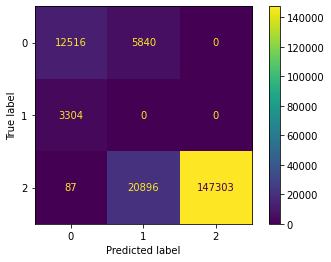

In [31]:
new_preds = [best_perm[k] for k in preds]
cm = confusion_matrix(kmeans.labels_, new_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format='')

In [32]:
f1_score(kmeans.labels_, new_preds, average = 'weighted')

0.8976632165398815

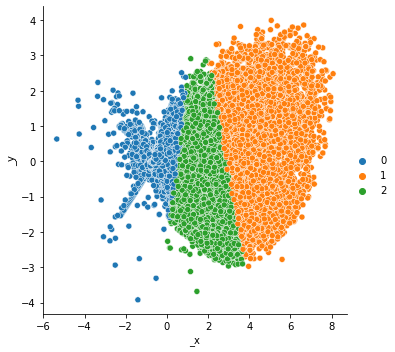

In [33]:
sns.relplot(x=pca2[:,0], y=pca2[:,1], hue=kmeans2.labels_, palette='tab10', kind='scatter')

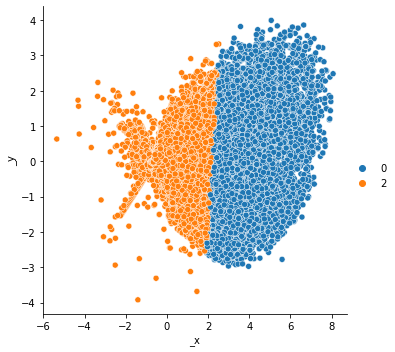

In [34]:
preds2 = kmeans.predict(X_clean_std)
sns.relplot(x=pca2[:,0], y=pca2[:,1], hue=preds2, palette='tab10', kind='scatter')

In [35]:
best_perm2, acc2 = label_permute_compare(kmeans2.labels_, preds2)
acc2

0.8635280867239195

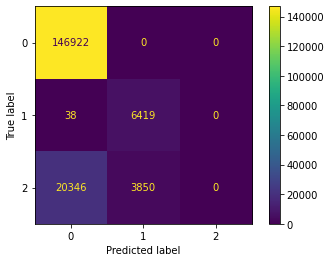

In [36]:
new_preds2 = [best_perm2[k] for k in preds2]
cm = confusion_matrix(kmeans2.labels_, new_preds2)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format='')

In [37]:
f1_score(kmeans2.labels_, new_preds2, average = 'weighted')

0.801617403393993

# K-medoids clustering

In [23]:
sample = np.random.RandomState(seed=0).permutation(X_std)[:10000]
sample2 = np.random.RandomState(seed=0).permutation(X_clean_std)[:10000]

In [24]:
kmeds = KMedoids(n_clusters=3, random_state=0).fit(sample)

In [25]:
kmeds2 = KMedoids(n_clusters=3, random_state=0).fit(sample2)

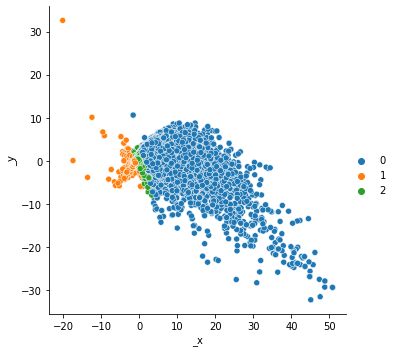

In [27]:
preds_meds = kmeds.predict(X_std)
sns.relplot(x=pca[:,0], y=pca[:,1], hue=preds_meds, palette='tab10', kind='scatter')

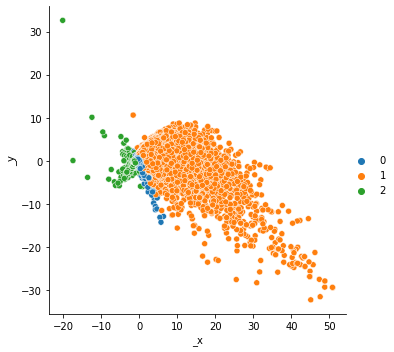

In [28]:
preds_meds2 = kmeds2.predict(X_std)
sns.relplot(x=pca[:,0], y=pca[:,1], hue=preds_meds2, palette='tab10', kind='scatter')

In [30]:
best_perm3, acc3 = label_permute_compare(preds_meds, preds_meds2)
acc3

0.9041780295452392

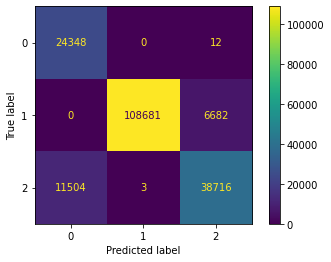

In [33]:
new_preds3 = [best_perm3[k] for k in preds_meds2]
cm = confusion_matrix(preds_meds, new_preds3)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format='')

In [37]:
f1_score(preds_meds, new_preds3, average = 'weighted')

0.907027867591263

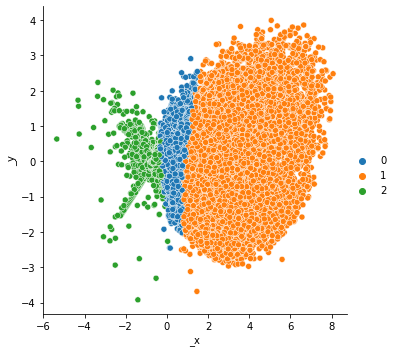

In [38]:
preds_meds3 = kmeds2.predict(X_clean_std)
sns.relplot(x=pca2[:,0], y=pca2[:,1], hue=preds_meds3, palette='tab10', kind='scatter')

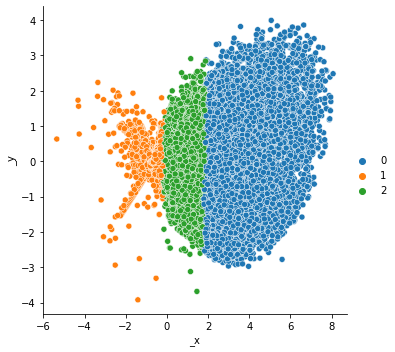

In [39]:
preds_meds4 = kmeds.predict(X_clean_std)
sns.relplot(x=pca2[:,0], y=pca2[:,1], hue=preds_meds4, palette='tab10', kind='scatter')

In [40]:
best_perm4, acc4 = label_permute_compare(preds_meds3, preds_meds4)
acc4

0.8994453048007884

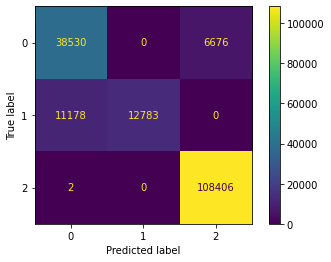

In [41]:
new_preds4 = [best_perm4[k] for k in preds_meds4]
cm = confusion_matrix(preds_meds3, new_preds4)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format='')

In [43]:
f1_score(preds_meds3, new_preds4, average = 'weighted')

0.8928178011133047

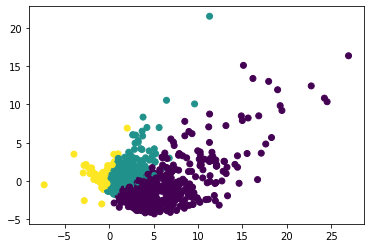

In [ ]:
kmeds = KMedoids(n_clusters=3)
kmeds.fit(X_std[:10000])

scatter_pts = pca_2.fit_transform(X_std[:10000])
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = kmeds.labels_)

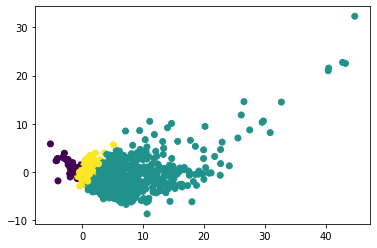

In [ ]:
sample = np.random.permutation(X_std)[:10000]
kmeds = KMedoids(n_clusters=3)
kmeds.fit(sample)

scatter_pts = pca_2.fit_transform(sample)
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = kmeds.labels_)

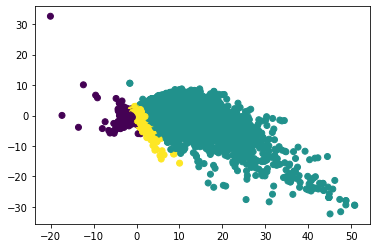

In [ ]:
preds = kmeds.predict(X_std)
scatter_pts = pca_2.fit_transform(X_std)
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = preds)

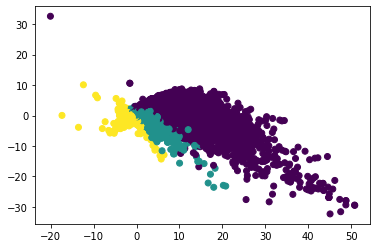

In [ ]:
preds = kmeds.predict(X_std)
scatter_pts = pca_2.fit_transform(X_std)
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = preds)

Use one PCA and keep axis the same to illustrate. Use seaborn.

In [ ]:
np.random.permutation(A)[:2]

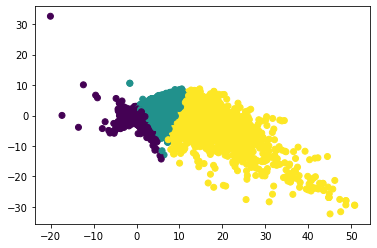

In [ ]:
scatter_pts = pca_2.fit_transform(X_std)
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = kmeans.labels_)

(-35.0, 35.0)

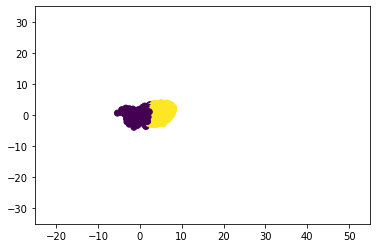

In [ ]:
scatter_pts = pca_2.fit_transform(X_clean_std)
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = kmeans.predict(X_clean_std))
plt.xlim(-25, 55)
plt.ylim(-35, 35)

(-35.0, 35.0)

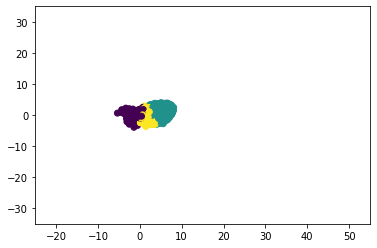

In [ ]:
scatter_pts = pca_2.fit_transform(X_clean_std)
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = kmeans2.labels_)
plt.xlim(-25, 55)
plt.ylim(-35, 35)

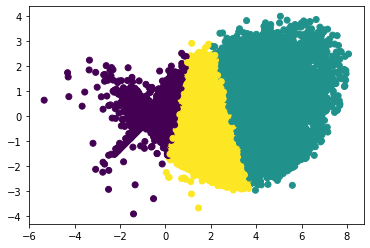

In [ ]:
scatter_pts = pca_2.fit_transform(X_clean_std)
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = kmeans2.labels_)

(-35.0, 35.0)

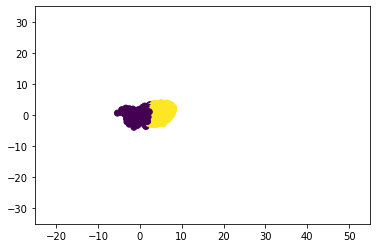

In [ ]:
scatter_pts = pca_2.fit_transform(X_clean_std)
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = kmeans.predict(X_clean_std))
plt.xlim(-25, 55)
plt.ylim(-35, 35)

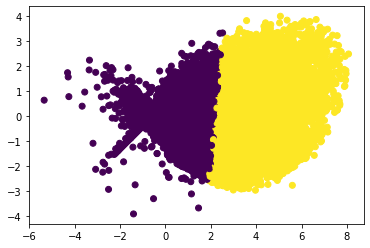

In [ ]:
scatter_pts = pca_2.fit_transform(X_clean_std)
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = kmeans.predict(X_clean_std))

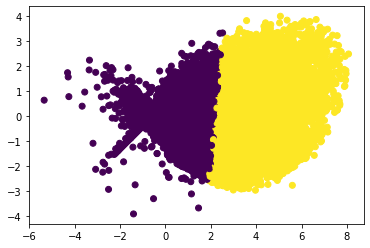

In [ ]:
scatter_pts = pca_2.fit_transform(X_clean_std)
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = kmeans.predict(X_clean_std))

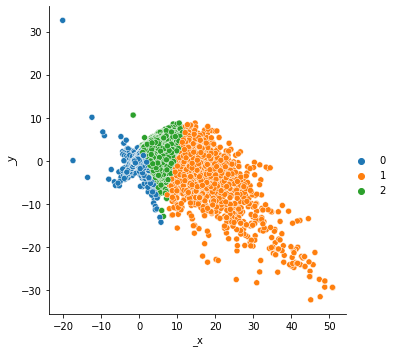

In [ ]:

sns.relplot(x=scatter_pts[:,0], y=scatter_pts[:,1], hue=kmeans.labels_, palette='tab10', kind='scatter')

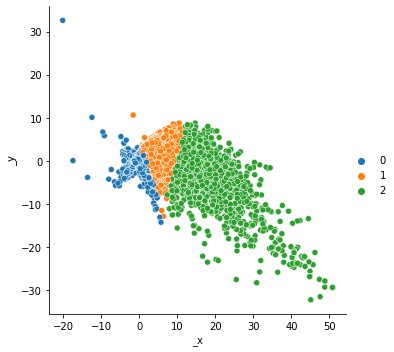

In [ ]:
sns.relplot(x=scatter_pts[:,0], y=scatter_pts[:,1], hue=kmeans.labels_, palette='tab10', kind='scatter')

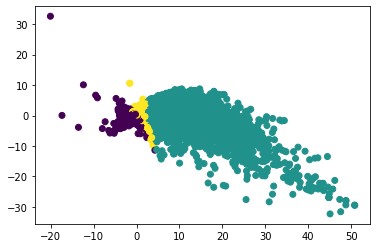

In [ ]:
scatter_pts = pca_2.fit_transform(X_std)
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = kmeans2.predict(X_std))

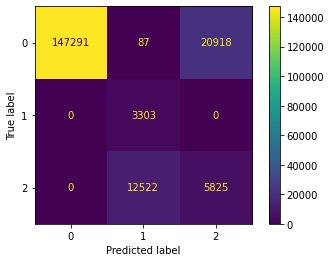

In [ ]:
cm = confusion_matrix(kmeans.labels_, kmeans2.predict(X_std))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
np.mean(kmeans.labels_ == kmeans2.predict(X_std))

0.8234919398144736

In [ ]:
sklearn.metrics.f1_score(kmeans.labels_, kmeans2.predict(X_std), average = 'weighted')

0.8579826597571799

TypeError: ignored

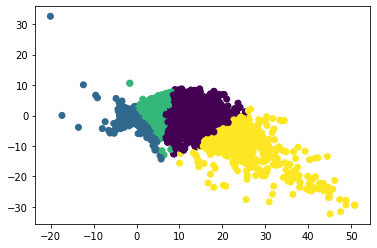

In [ ]:
from matplotlib import pyplot as plt
scatter_pts = pca_2.fit_transform(X_std)
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = kmeans3.labels_)
plt.legend(kmeans3.labels_())

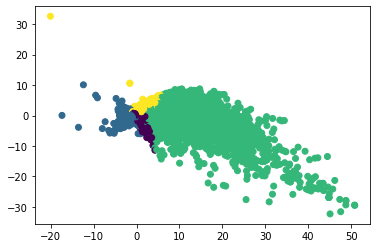

In [ ]:
from matplotlib import pyplot as plt
scatter_pts = pca_2.fit_transform(X_std)
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = kmeans4.predict(X_std))

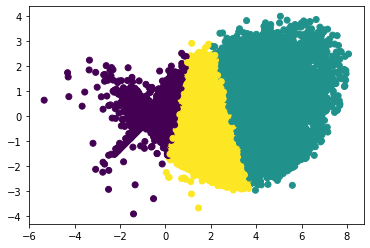

In [ ]:
from matplotlib import pyplot as plt
scatter_pts = pca_2_2.fit_transform(X_clean_std)
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = kmeans2.labels_)

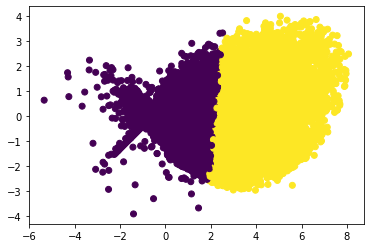

In [ ]:
from matplotlib import pyplot as plt
scatter_pts = pca_2_2.fit_transform(X_clean_std)
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = kmeans.predict(X_clean_std))

In [ ]:
np.mean(kmeans2.labels_ == kmeans.predict(X_clean_std))

0.8489258059974658

In [ ]:
sklearn.metrics.f1_score(kmeans2.labels_, kmeans.predict(X_clean_std), average = 'weighted')

0.8039472416556526

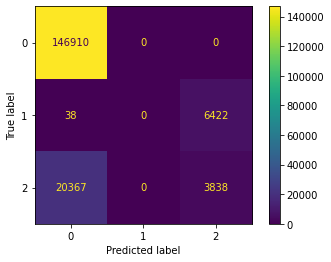

In [ ]:
cm = confusion_matrix(kmeans2.labels_, kmeans.predict(X_clean_std))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format='')

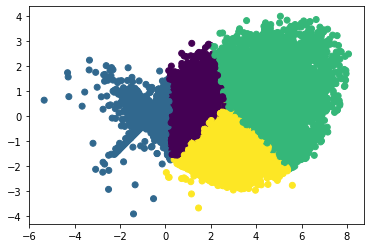

In [ ]:
from matplotlib import pyplot as plt
scatter_pts = pca_2_2.fit_transform(X_clean_std)
plt.scatter(scatter_pts[:,0], scatter_pts[:,1], c = kmeans4.labels_)

In [ ]:
len(scatter_pts[:100,0])

100

# Results Summary

|Metric|All Pos. Bench.|LR w/ outliers|LR w/ thresh. adj.|AdaBoost, n_est=100|AdaBoost small to large|XGBoost, n_est=100|XGBoost small to large|
|:----|:--------|:--------|:--------|:--------|:--------|:--------|:--------:|
|Accuracy|0.760|0.759|0.825|0.839|0.708|0.860|0.863|
|F$_{1}$|0.865|0.855|0.885|0.896|0.793|0.910|0.911|
|AUC|0.500|0.787|0.834|0.865|0.747|0.898|0.886|


# Conclusion

# References
(Sloane, 1964) https://oeis.org/

(Bieber, 2020) https://davidbieber.com/snippets/2020-06-28-oeis-download/